In [14]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import matplotlib.pyplot as plt

In [2]:
# 이번 튜토리얼에서 사용할 데이터를 가져온다.
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = os.path.join(os.path.dirname(archive),'flower_photos')


228813984/228813984 [==============================] - 1s 0us/step


In [3]:
# 이미지가 총 몇개인지 확인해본다.
image_count = len(glob.glob(os.path.join(data_dir,'*/*.jpg')))
print(image_count)

3670


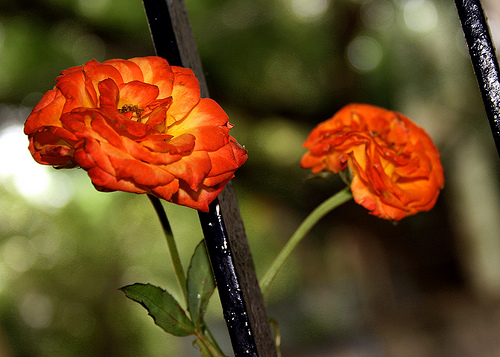

In [4]:
# 이미지를 하나 불러와서 띄워본다.
roses = list(glob.glob(os.path.join(data_dir,'roses/*')))
PIL.Image.open(str(roses[0]))

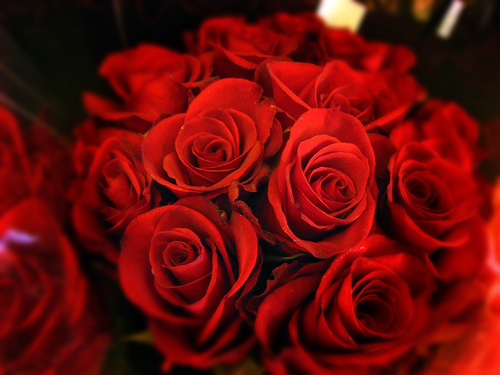

In [5]:
PIL.Image.open(roses[2])

## Load data using a keras utility

In [6]:
# batch_size 및 학습에 사용할 이미지의 크기를 지정해준다. 
batch_size = 32
img_height = 180
img_width = 180

# 케라스 api를 활용해 디렉토리별로 분류하여 데이터셋을 만든다.
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 2023,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 2023,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
# 사진이 들어있던 폴더명이 클래스로 저장되어있다.
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


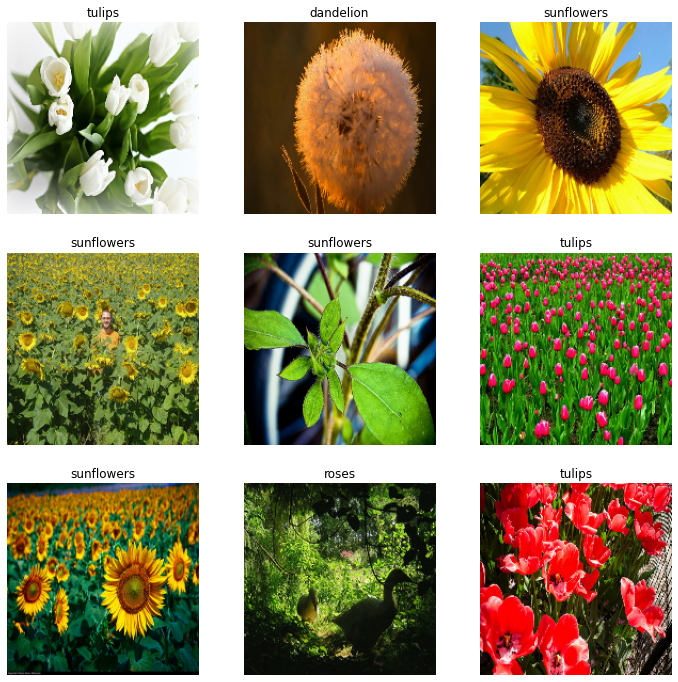

In [9]:
# train데이터에 이미지가 잘 데이터셋화 되었는지 일부 확인해본다.
plt.figure(figsize =(12,12))
for img, label in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')
plt.show()

In [10]:
# 배치내의 shape이 의도한 것과 같은지 확인해본다.
for img_batch, label_batch in train_ds:
    print(img_batch.shape)
    print(label_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### 데이터 표준화
RGB 채널의 값은 [0,255] 사이에 있으므로 [0,1]사이로 표준화해준다

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x,y : (normalization_layer(x), y))
img_batch, labels_batch = next(iter(normalized_ds))
first_img = img_batch[0]
print(np.min(first_img), np.max(first_img))

0.0 0.9994554


### 성능향상을 위한 데이터셋 구성
Dataset.chache : 첫 에포크의 이미지를 메모리에 유지시켜서 학습이 반복되는 과정에서 발생할 수 있는 병목현상을 예방해준다<br>
Dataset.prefetch : 학습하는 동안 다음 학습에 사용할 데이터를 준비합니다. 이렇게 진행할 경우 메모리의 사용은 늘어나지만 대부분의 경우 시간이 줄어들고 처리량이 늘어나는 효과를 얻을 수 있습니다.


In [18]:
# prefetch 에 사용될 버퍼가 자동 조정될 수 있도록 도와주는 tensorflow 의 api를 사용
AUTOTUNE = tf.data.AUTOTUNE
# cache() 와 prefetch()가 적용 될 수 있도록 데이터셋을 변경해준다.
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

### 학습을 위한 모델준비

In [19]:
num_classes = 5

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    # stride 값은 3, 필터의 개수는 32개라는 의미이다. ex) input이 (32,60,60,3) 이면 output은 (32,58,58,32)이 된다.
    tf.keras.layers.Conv2D(32,3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32,3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32,3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy']
)

In [21]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 3
)

Epoch 1/3
92/92 [==============================] - 16s 165ms/step - loss: 1.3523 - accuracy: 0.4281 - val_loss: 1.1340 - val_accuracy: 0.5136
Epoch 2/3
92/92 [==============================] - 15s 160ms/step - loss: 1.0326 - accuracy: 0.5828 - val_loss: 0.9806 - val_accuracy: 0.6022
Epoch 3/3
92/92 [==============================] - 15s 161ms/step - loss: 0.8688 - accuracy: 0.6621 - val_loss: 0.9467 - val_accuracy: 0.6308
